## Neural Networks applied to Structure Health Monitoring using autoregressive models as feature extractors
Felipe da Costa Pereira - (felipecostapereira@gmail.com)   
PUC-RJ - ELE2389 - Redes Neurais - Trabalho Final    
Professora: Marley Vellasco

### Initial setup, method definitions

Importing libraries

In [3]:
import scipy.io as sio
from scipy import stats
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tqdm.notebook import tqdm

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
import matplotlib.lines as mlines

#neural networks
import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

# other classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.model_selection import KFold, RepeatedKFold, RandomizedSearchCV

Saving and retrieving elements with pickle

In [4]:
import pickle
  
def save_element(obj, filename):
    '''
    function to save a python instance to disk
    
    ## INPUTS:
    obj: any object
    filename - file name
    '''
    obj_file = open(filename, 'ab')
    pickle.dump(obj, obj_file)                     
    obj_file.close()
  
def load_element(filename):
    '''
    function to read a python instance from disk    
        
    ## INPUTS:
    filename - file name
    ## RETURNS:
    obj: any object
    '''
    # for reading also binary mode is important
    obj_file = open(filename, 'rb')     
    obj = pickle.load(obj_file)
    obj_file.close()
    return obj

Torch Neural Network class, accuracy and binary accuracy score and train (with early stop implemented)

In [5]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

class NeuralNetwork_2h(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork_2h, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha1 = self.activations[hidden_activation]
    self.ha2 = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha1(h) 
    h2 = self.ha2(h1) 
    y = self.fc2(h2) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred

def accuracy(y_pred, y_test):
    y_pred_tags = torch.argmax(y_pred, dim=1)
    
    correct_pred = (y_pred_tags == y_test).float().sum()
    acc = correct_pred / y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def binary_acc(y_pred, y_test):
    y_pred_tags = torch.round(torch.sigmoid(y_pred))

    correct_pred = (y_pred_tags == y_test).float().sum()
    acc = correct_pred/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def train_early_stop(model, train_loader, val_set, epochs, device, lr, binary=True, skip=1, max_patience=10): 

  if binary:
    criterion = nn.BCEWithLogitsLoss()
  else:
    criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

  # for e in tqdm(range(1, epochs+1)):
  for e in range(1, epochs+1):
    
    y_hat = np.array([])

    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X, y = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        #acc = accuracy(y_pred, y)
        #Para classificação binária
        if binary:
          acc = binary_acc(y_pred,y)
        else:
          acc = accuracy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
        y_p = torch.argmax(y_pred, dim=1)
        y_hat = np.concatenate((y_hat, y_p))
    
    
    model.eval()
    _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

    # Early Stop
    # min val é o menor valor de loss do hist, a rede continua aprendendo
    # patience = 0
    if e == 1: min_val = 100
    if val_loss < min_val:
      min_val = val_loss
      patience = 0
    else:
      patience += 1
      if patience == max_patience:
        print ('***************************************************')
        print ('*******************ES achieved !*******************')
        print ('***************************************************')
        return history, y_hat

    history['acc_train'].append(train_epoch_acc/len(train_loader))
    history['loss_train'].append(train_epoch_loss/len(train_loader))
    history['acc_val'].append(val_acc)
    history['loss_val'].append(val_loss)
    
    if e%skip == 0:
      print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}| Patience: {patience:d}')
  return history, y_hat

def evaluate(model, val_set, criterion, binary=True):
    X = val_set.X_data
    y = val_set.y_data

    with torch.no_grad():
      y_pred = model(X)
                
    loss = criterion(y_pred, y)
    
    #Para classificação binária
    if binary:
      acc = binary_acc(y_pred, y)
    else:
      acc = accuracy(y_pred, y)

    val_epoch_loss = loss.item()
    val_epoch_acc = acc
    
    return y_pred, val_epoch_loss, val_epoch_acc

In [6]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Data Loading and preprocessing

Opening data file and Separating parameters and labels

In [8]:
fname = join(getcwd(),'./datasets','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
target = mat_contents['labels'].reshape(Nc)

Creating classification labels, bayond the 17 classes:
- 4 groups
- binary class


In [9]:
target_bin = []
for label in target:
    if label in range(1,10):
        target_bin.append(0)
    else: target_bin.append(1)
target_bin = np.array(target_bin)

target_group = []
for label in target:
    if label in range(2,10):
        target_group.append(1)
    elif label in range(10,15):        
        target_group.append(2)
    elif label in range(14,18):
        target_group.append(3)
    else: target_group.append(0)
target_group = np.array(target_group)

Plot 17 state conditions grouping

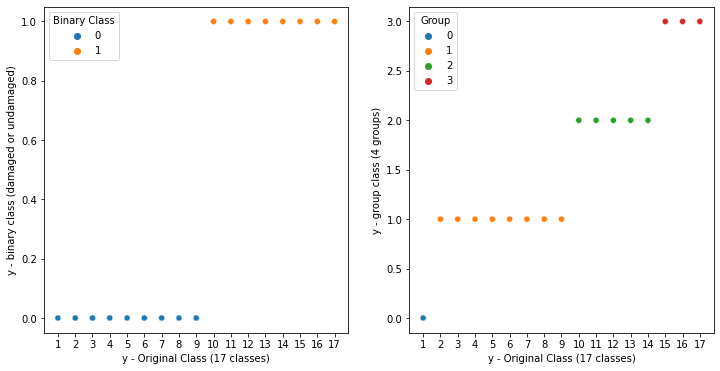

In [10]:
target_bin = np.array(target_bin)
target_group = np.array(target_group)

fig, axes = plt.subplots(1,2,figsize=(12,6))

sns.scatterplot(x=target,y=target_bin, hue=target_bin, ax=axes[0])
sns.scatterplot(x=target,y=target_group, hue=target_group, ax=axes[1], palette='tab10')

axes[0].legend(title='Binary Class')
axes[1].legend(title='Group')

axes[0].set_xticks(np.arange(1,18,1))
axes[1].set_xticks(np.arange(1,18,1))

axes[0].set_xlabel('y - Original Class (17 classes)')
axes[1].set_xlabel('y - Original Class (17 classes)')

axes[0].set_ylabel('y - binary class (damaged or undamaged)')
axes[1].set_ylabel('y - group class (4 groups)')

pass;

Plotting data from accelerometers

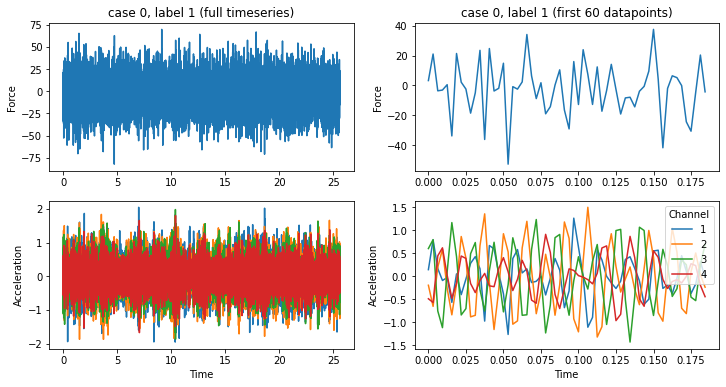

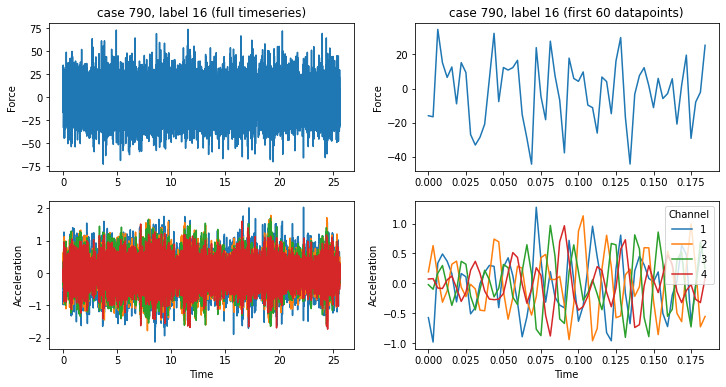

In [11]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

datapoints = 60

for case in np.array([0,790]):
    plt.subplots(figsize=(12,6))

    plt.subplot(221)
    plt.plot(time,Ch1[:,case])
    plt.title('case %d, label %d (full timeseries)' % (case, target[case]))
    plt.ylabel('Force')

    plt.subplot(222)
    plt.title('case %d, label %d (first %d datapoints)' % (case, target[case], datapoints))
    plt.plot(time[:datapoints],Ch1[:datapoints,case])
    plt.ylabel('Force')

    plt.subplot(223)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.ylabel('Acceleration')
    plt.xlabel('Time')
    
    plt.subplot(224)
    plt.plot(time[:datapoints],Ch2[:datapoints,case],time[:datapoints],Ch3[:datapoints,case],time[:datapoints],Ch4[:datapoints,case],time[:datapoints],Ch5[:datapoints,case])
    
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.legend(['1','2','3','4'], title='Channel')
    plt.show()
pass;



### Feature Extraction and Dimensionallity Reduction

Building AR Model

In [12]:
modelOrder = 30

x2 = dataset[:,1,:].transpose() # acelerômetro: base
x3 = dataset[:,2,:].transpose() # acelerômetro: 1o andar
x4 = dataset[:,3,:].transpose() # acelerômetro: 2o andar
x5 = dataset[:,4,:].transpose() # acelerômetro: 3o andar

x2r = [] 
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1, old_names=True).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1, old_names=True).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1, old_names=True).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1, old_names=True).fit()
    x5r.append(res.params)

X_AR = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
pass;

X1 Shape 850 lines and (4 channels x 30 features/channel) features 

In [13]:
X_AR.shape



(850, 120)

Dimensionallity Reduction (PCA)

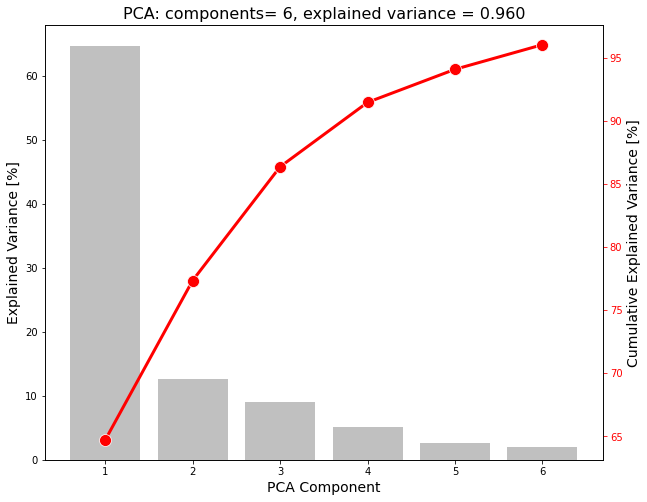

In [14]:
nComponents = 0.96  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X_AR)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i+1 for i in range(len(pcaVariances))]

fig = plt.figure(figsize=(10,8))
ax = sns.barplot(x=pcaComponents, y=pcaVariances*100, color='silver');
ax2 = ax.twinx()
ax2 = sns.lineplot(x=np.asarray(pcaComponents)-1, y=np.cumsum(pcaVariances)*100, lw=3, ms=12, marker='o', color='r');
ax.tick_params(axis='y', colors='k')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: components= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5], fontsize=16)
ax.set_xlabel('PCA Component', fontsize=14)
ax.set_ylabel('Explained Variance [%]', fontsize=14)
ax2.set_ylabel('Cumulative Explained Variance [%]', fontsize=14)
pass;

Building X2 by transforming the x1 data with the previous PCA model and scaling X2

In [15]:
X_PCA = pca.fit_transform(X_AR)
X_PCA = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_PCA)

X_PCA.shape

(850, 6)

Correlation matrix before and after PCA

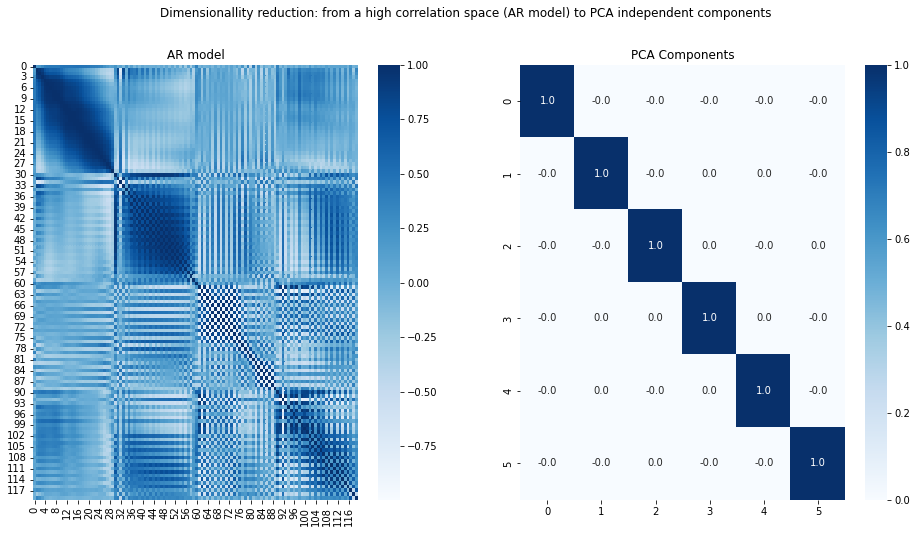

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,8))

plt.subplot(121)
ax = sns.heatmap(np.corrcoef(X_AR, rowvar=False), cmap='Blues')
ax.set_title('AR model')

plt.subplot(122)
ax2 = sns.heatmap(np.corrcoef(X_PCA, rowvar=False), annot=True, fmt='.1f', cmap='Blues')
ax2.set_title('PCA Components')

fig.suptitle('Dimensionallity reduction: from a high correlation space (AR model) to PCA independent components')

pass;

Plotting AR coefficients (mean) for each channel

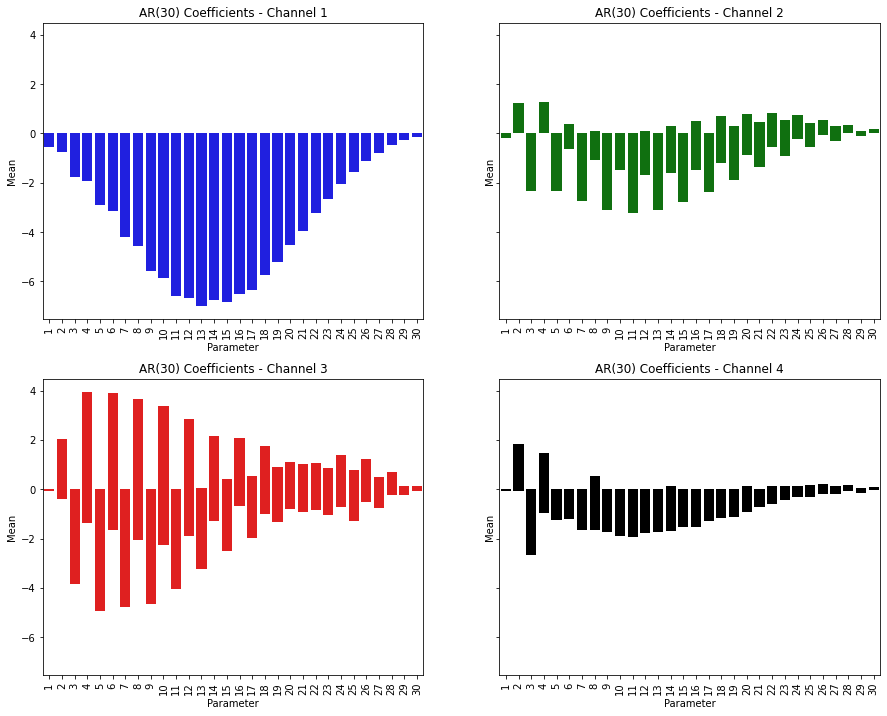

In [17]:
fig,ax = plt.subplots(2,2,figsize=(15,12), sharey=True)
ax = ax.flatten()

step = 10

xRange = [i+1 for i in range(30)]
xRangeAll = [i+1 for i in range(120)]

for v in X_AR[::step]:
    sns.barplot(x=xRange, y=v[:30]  , ax=ax[0], color='b')
    sns.barplot(x=xRange, y=v[30:60], ax=ax[1], color='g')
    sns.barplot(x=xRange, y=v[60:90], ax=ax[2], color='r')
    sns.barplot(x=xRange, y=v[90:]  , ax=ax[3], color='k')
    
for i,a in enumerate(ax):
    a.set_title(f'AR(30) Coefficients - Channel {i+1:d}');
    a.set_xlabel('Parameter');
    a.set_ylabel('Mean');
    # a.set_xticks(np.asarray(xRange)+.5)
    a.set_xticklabels(xRange, rotation=90)
pass;


Concatenating AR coefficients into a 120 features space, for each of the 850 cases.

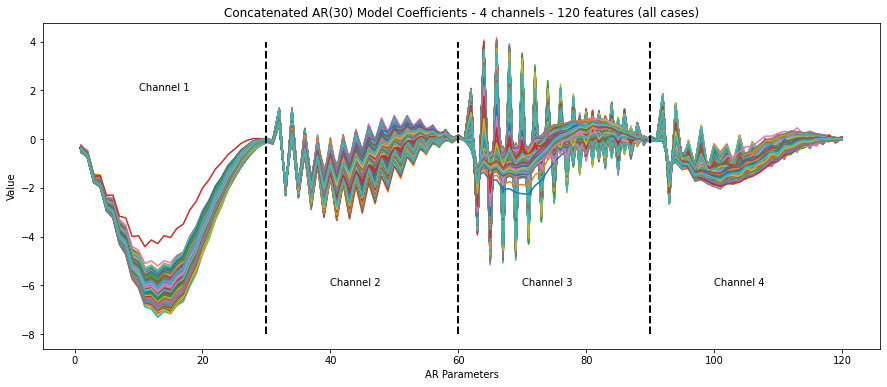

In [18]:
fig = plt.figure(figsize=(15,6))

step = 1

for v in X_AR[::step]:
    sns.lineplot(x=xRangeAll, y=v)

plt.plot([30,30], [-8,4], '--k', [60,60], [-8,4], '--k', [90,90], [-8,4], '--k', linewidth=2)
plt.annotate('Channel 1', (10,2))
plt.annotate('Channel 2', (40,-6))
plt.annotate('Channel 3', (70,-6))
plt.annotate('Channel 4', (100,-6))

plt.title(f'Concatenated AR(30) Model Coefficients - 4 channels - 120 features (all cases)')
plt.xlabel('AR Parameters')
plt.ylabel('Value')
pass;

Correlation matrix in the 120 features input space

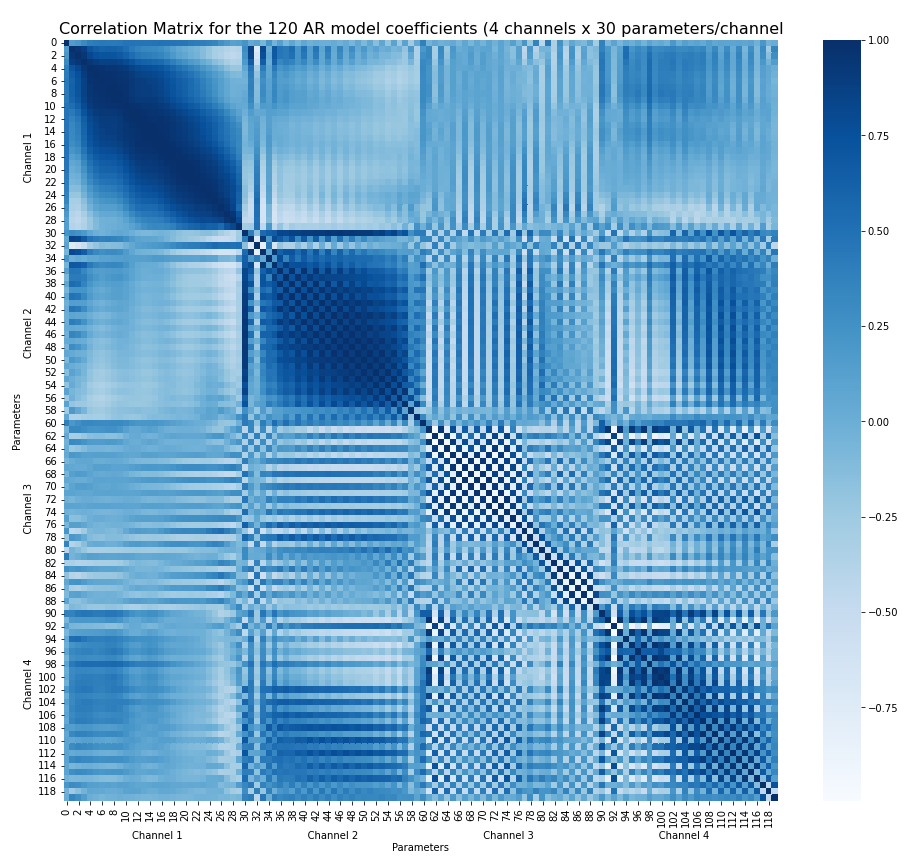

In [19]:
fig = plt.figure(figsize=(16,14))

space=40

sns.heatmap(np.corrcoef(X_AR, rowvar=False), cmap='Blues')
plt.xlabel(f'{space * " "}Channel 1{space * " "}Channel 2{(space) * " "}Channel 3{space * " "}Channel 4{space * " "}\nParameters')
plt.ylabel(f'Parameters\n{space * " "}Channel 4{space * " "}Channel 3{(space) * " "}Channel 2{space * " "}Channel 1{space * " "}')
plt.title('Correlation Matrix for the 120 AR model coefficients (4 channels x 30 parameters/channel', fontsize=16)
pass;

Correlation matrix for each of the 30 features channel

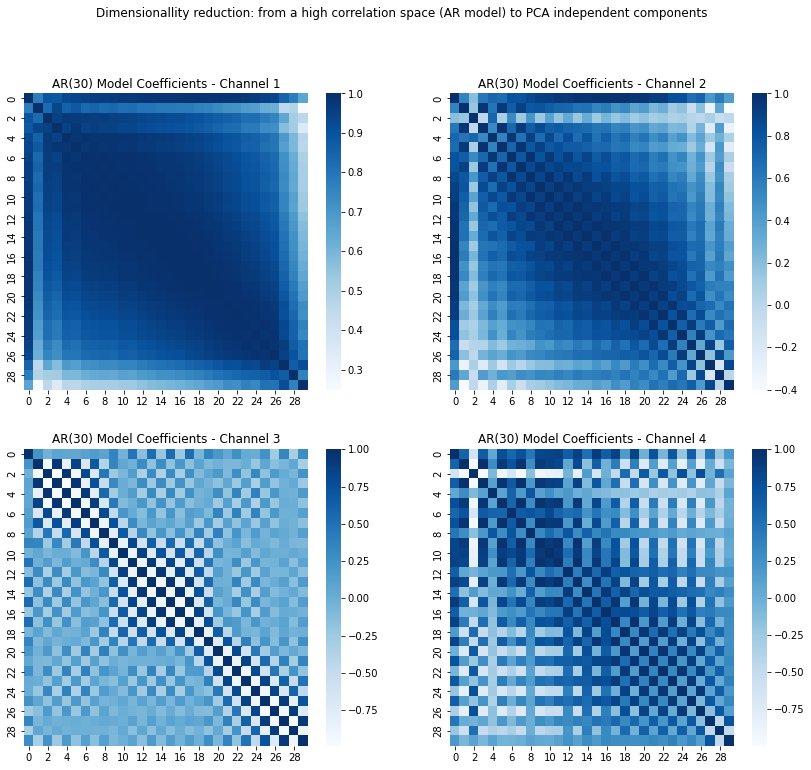

In [20]:
fig,ax = plt.subplots(2,2,figsize=(14,12))
ax = ax.flatten()

sns.heatmap(np.corrcoef(X_AR[:30,:30], rowvar=False), cmap='Blues', ax=ax[0])
plt.title('AR(30) Model Coefficients - Channel 1')
sns.heatmap(np.corrcoef(X_AR[30:60,30:60], rowvar=False), cmap='Blues', ax=ax[1] )
plt.title('AR(30) Model Coefficients - Channel 2')
sns.heatmap(np.corrcoef(X_AR[60:90,60:90], rowvar=False), cmap='Blues', ax=ax[2] )
plt.title('AR(30) Model Coefficients - Channel 3')
sns.heatmap(np.corrcoef(X_AR[90:,90:], rowvar=False), cmap='Blues', ax=ax[3] )
# plt.xticks([i+1 for i in range(120)])

for i,a in enumerate(ax):
    a.set_title(f'AR(30) Model Coefficients - Channel {i+1:d}')

fig.suptitle('Dimensionallity reduction: from a high correlation space (AR model) to PCA independent components')

pass;

### Exploratory Analysis

Building a pandas dataframe for plotting purposes

In [21]:
dfX_PCA = pd.DataFrame(X_PCA)
dfX_PCA['target'] = target
dfX_PCA['target_bin'] = target_bin
dfX_PCA['target_group'] = target_group
dfX_PCA.set_axis([1,2,3,4,5,6,'target','target_bin','target_group'], axis=1, inplace=True)

dfX_PCA_melt = dfX_PCA.melt(id_vars=['target','target_bin', 'target_group'], var_name='pca_component')

Visualizing data

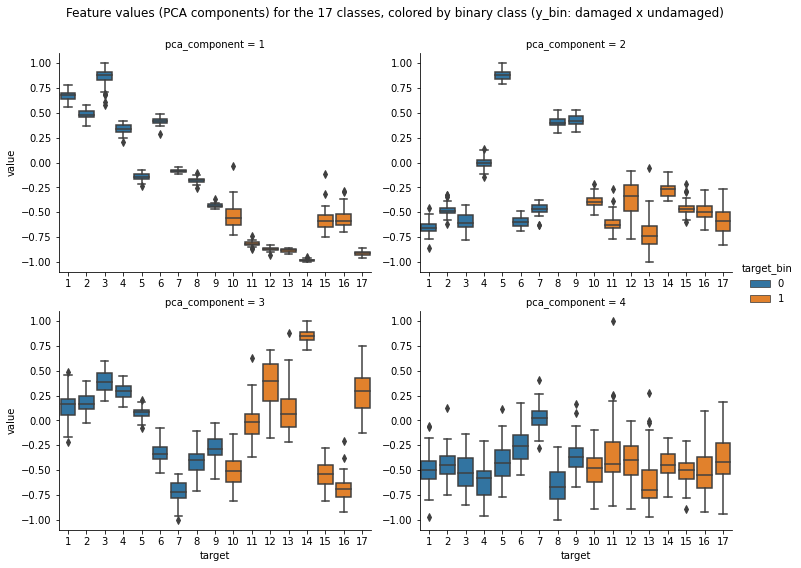

In [22]:
ax = sns.catplot(data=dfX_PCA_melt[dfX_PCA_melt['pca_component'] <= 4], dodge=False, col='pca_component', \
    y='value', x='target', col_wrap=2, kind='box', hue='target_bin', height=4, aspect=1.3, margin_titles=True, sharex=False, sharey=False)

ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle(f'Feature values (PCA components) for the 17 classes, colored by binary class (y_bin: damaged x undamaged)')
pass;

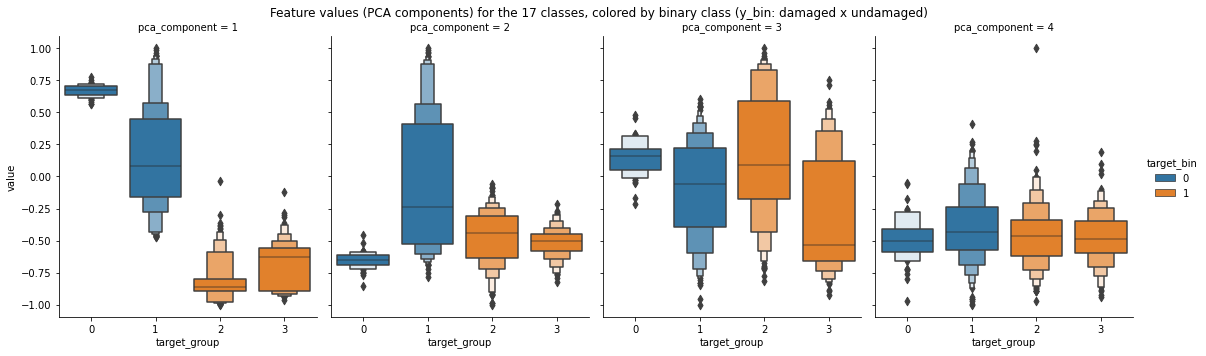

In [23]:
ax = sns.catplot(data=dfX_PCA_melt[dfX_PCA_melt['pca_component'] <= 4], col='pca_component', dodge=False, y='value', x='target_group', col_wrap=4, kind='boxen', hue='target_bin', height=5, aspect=.8, margin_titles=True);

ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle(f'Feature values (PCA components) for the 17 classes, colored by binary class (y_bin: damaged x undamaged)')
pass;

Pairplots using PCA components, by class

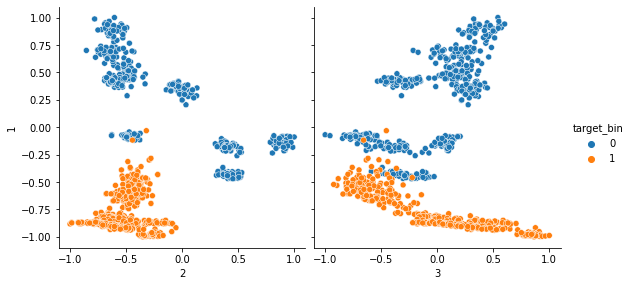

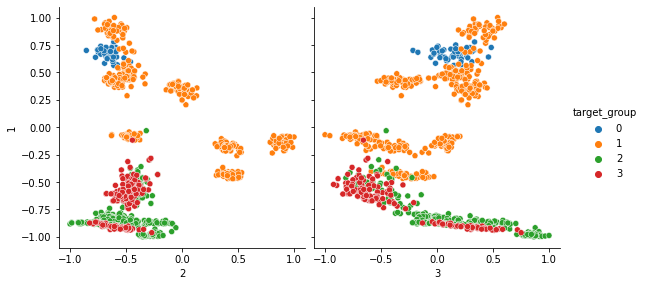

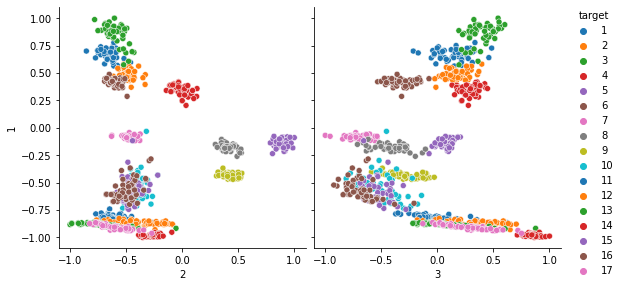

In [24]:
h=4

yvar=[1]
xvar=[2,3]
sns.pairplot(data=dfX_PCA, x_vars=xvar, y_vars=yvar, hue='target_bin', diag_kind='kde', palette='tab10', height=h);
# plt.suptitle('Pairwise cross plots for the 3 pca components (grouped by binary class: damaged x undamaged)', y=y);

sns.pairplot(data=dfX_PCA, x_vars=xvar, y_vars=yvar, hue='target_group', diag_kind='kde', palette='tab10', height=h);
# plt.suptitle('Pairwise cross plots for the 3 pca components (grouped by group of state)', y=y);

sns.pairplot(data=dfX_PCA, x_vars=xvar, y_vars=yvar, hue='target', diag_kind='kde', palette='tab10', height=h);
# plt.suptitle('Pairwise cross plots for the 3 pca components, (grouped by class: 17 state conditions)', y=y);

pass;


### Neural Network

Creating seeds

In [25]:
X = X_PCA
n_input = X.shape[1]
batch_size = 32 
test_size = 0.2

n_seeds = 10    
random_seeds = [random.randint(1,200) for i in range(n_seeds)]

Parametrization, manually tested for a set of combinations

In [177]:
hidden_neurons = 2 * n_input + 1
lr = 0.05
epochs = 500
hidden_activation = 'relu'

Setting k-fold instance

In [178]:
k_folds = 5
n_repeats = 3

# simple k fold
kf = KFold(n_splits=k_folds, shuffle=True)

# repeated k fold
rkf = RepeatedKFold(n_splits=k_folds, n_repeats=n_repeats, random_state=10)

Chosing k-fold method, with or without repetition

In [179]:
# k_fold = kf
k_fold = rkf

Memory reserve for saving results

In [180]:
accuracies_ann=[]
accuracies_ann_group=[]

cms_ann=[]
cms_ann_group=[]

ANN 4 outputs

In [181]:
# training problem = 04 groups
for rs in tqdm (random_seeds):
  print ('rs=', rs)
  encoder = LabelEncoder()
  y = encoder.fit_transform(target_group)

  if np.unique(y).shape[0] <= 2:
    n_output = 1
    binary = True
  else:
    n_output = len(encoder.classes_)
    binary = False
  
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=rs)
  
  # k-fold x-validation
  best_val_loss = 1000
  best_model = None
  for i, (train_indexes, test_indexes) in enumerate(k_fold.split(X)):
    print ('fold', i+1, end=' ')

    X_train, X_val, y_train, y_val = X[train_indexes], X[test_indexes], y[train_indexes ], y[test_indexes]

    if binary:
      train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
      val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
      test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    else:
      train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
      val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
      test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = NeuralNetwork(n_input = n_input, hidden_activation=hidden_activation, hidden_neurons=hidden_neurons, n_output=n_output, output_activation='sigmoid')
    hist, _ = train_early_stop(model, train_loader, val_dataset, device=device, epochs=epochs, lr=lr, binary=binary, max_patience=10, skip=epochs+1)
    print ('loss:', hist['loss_val'][-1])
    
    if hist['loss_val'][-1] < best_val_loss:
      best_val_loss = hist['loss_val'][-1]
      best_model = model

  print (f'best loss: {best_val_loss}\n')
    
  y_pred = best_model.predict(test_dataset.X_data, binary=binary)
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  acc = accuracy_score(y_test, y_pred)
  accuracies_ann_group.append(acc)
  cms_ann_group.append(cm)    

  0%|          | 0/10 [00:00<?, ?it/s]

rs= 74
fold 1 loss: 0.1157926470041275
fold 2 loss: 0.11104443669319153
fold 3 loss: 0.12637250125408173
fold 4 loss: 0.14112074673175812
fold 5 loss: 0.17834530770778656
fold 6 loss: 0.06355848908424377
fold 7 loss: 0.26907020807266235
fold 8 loss: 0.0960797369480133
fold 9 loss: 0.1740058809518814
fold 10 loss: 0.14444972574710846
fold 11 loss: 0.23248636722564697
fold 12 loss: 0.09292013198137283
fold 13 loss: 0.16137678921222687
fold 14 loss: 0.11088835448026657
fold 15 loss: 0.16002920269966125
best loss: 0.06355848908424377

rs= 56
fold 1 loss: 0.11300108581781387
fold 2 loss: 0.10952246189117432
fold 3 loss: 0.12097316980361938
fold 4 loss: 0.12761101126670837
fold 5 loss: 0.12871912121772766
fold 6 loss: 0.09436412155628204
fold 7 loss: 0.1892257034778595
fold 8 loss: 0.09640933573246002
fold 9 loss: 0.1687769889831543
fold 10 loss: 0.133853942155838
fold 11 loss: 0.21258367598056793
fold 12 loss: 0.09794803708791733
fold 13 loss: 0.125352680683136
fold 14 loss: 0.1048078685998

Treinando ann para prever 17 classes

In [182]:
for rs in tqdm (random_seeds):
  print ('rs=', rs)
  encoder = LabelEncoder()
  y = encoder.fit_transform(target)

  if np.unique(y).shape[0] <= 2:
    n_output = 1
    binary = True
  else:
    n_output = len(encoder.classes_)
    binary = False
  
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=rs)
  
  # k-fold x-validation
  best_val_loss = 1000
  best_model = None
  for i, (train_indexes, test_indexes) in enumerate(k_fold.split(X)):
    print ('fold', i+1, end=' ')

    X_train, X_val, y_train, y_val = X[train_indexes], X[test_indexes], y[train_indexes ], y[test_indexes]

    if binary:
      train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
      val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
      test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
    else:
      train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
      val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
      test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)

    model = NeuralNetwork(n_input = n_input, hidden_activation=hidden_activation, hidden_neurons=hidden_neurons, n_output=n_output, output_activation='sigmoid')
    hist, _ = train_early_stop(model, train_loader, val_dataset, device=device, epochs=epochs, lr=lr, binary=binary, max_patience=10, skip=epochs+1)
    print ('loss:', hist['loss_val'][-1])
    
    if hist['loss_val'][-1] < best_val_loss:
      best_val_loss = hist['loss_val'][-1]
      best_model = model
    
  print (f'best loss: {best_val_loss}')
  # print ('index best loss:', val_loss.index(np.min(val_loss)))

  y_pred = best_model.predict(test_dataset.X_data, binary=binary)
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  acc = accuracy_score(y_test, y_pred)
  accuracies_ann.append(acc)
  cms_ann.append(cm)

  0%|          | 0/10 [00:00<?, ?it/s]

rs= 74
fold 1 loss: 0.2194836586713791
fold 2 loss: 0.19897492229938507
fold 3 loss: 0.2044118344783783
fold 4 loss: 0.21499451994895935
fold 5 loss: 0.21185488998889923
fold 6 loss: 0.1410711109638214
fold 7 loss: 0.28195467591285706
fold 8 loss: 0.19687940180301666
fold 9 loss: 0.2167011946439743
fold 10 loss: 0.17277006804943085
fold 11 loss: 0.24770613014698029
fold 12 loss: 0.179349884390831
fold 13 loss: 0.21900203824043274
fold 14 loss: 0.222682923078537
fold 15 loss: 0.224533349275589
best loss: 0.1410711109638214
rs= 56
fold 1 loss: 0.1942666471004486
fold 2 loss: 0.20937037467956543
fold 3 loss: 0.20836125314235687
fold 4 loss: 0.1916295289993286
fold 5 loss: 0.21580198407173157
fold 6 loss: 0.13130202889442444
fold 7 loss: 0.27294421195983887
fold 8 loss: 0.2096235156059265
fold 9 loss: 0.22195948660373688
fold 10 loss: 0.1587313413619995
fold 11 loss: 0.2530606687068939
fold 12 loss: 0.1766376942396164
fold 13 loss: 0.2144327014684677
fold 14 loss: 0.23352162539958954
fold 

saving objects

In [183]:
save_element(accuracies_ann, 'accuracies_ann')
save_element(accuracies_ann_group, 'accuracies_ann_group')

save_element(cms_ann, 'cms_ann')
save_element(cms_ann_group, 'cms_ann_group')

ANN 4 x 17 output

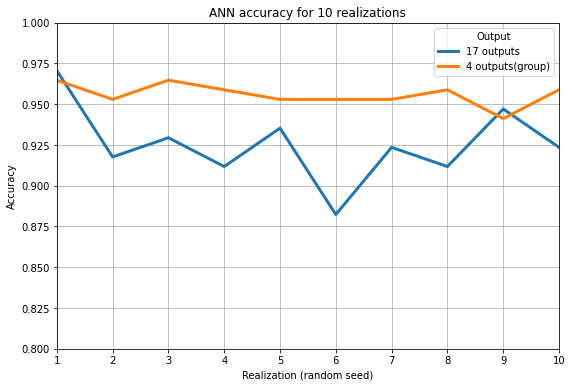

In [184]:
xlabels = [i+1 for i in range(n_seeds)]

plt.figure(figsize=(9,6))
sns.lineplot(x=xlabels, y=accuracies_ann, lw=3)
# sns.lineplot(x=xlabels, y=accuracies_ann_2h, lw=3)
sns.lineplot(x=xlabels, y=accuracies_ann_group, lw=3)

plt.grid()
plt.legend(['17 outputs', '4 outputs(group)'], title='Output')
plt.xlabel('Realization (random seed)')
plt.ylabel('Accuracy')
plt.title(f'ANN accuracy for {n_seeds} realizations')
plt.ylim([.80,1])
plt.xlim([1,n_seeds])
pass;

In [185]:
np.mean(accuracies_ann_group), np.max(accuracies_ann_group)
np.mean(accuracies_ann), np.max(accuracies_ann)

(0.9558823529411764, 0.9647058823529412)

(0.9252941176470589, 0.9705882352941176)

In [186]:
best_i_17 = accuracies_ann.index(np.max(accuracies_ann))
best_i_04 = accuracies_ann_group.index(np.max(accuracies_ann_group))

best_i_17
best_i_04

0

0

ANN results

In [187]:
cmap = 'Blues'

disp_ann = ConfusionMatrixDisplay(cms_ann[best_i_17])
disp_ann_group = ConfusionMatrixDisplay(cms_ann_group[best_i_04])

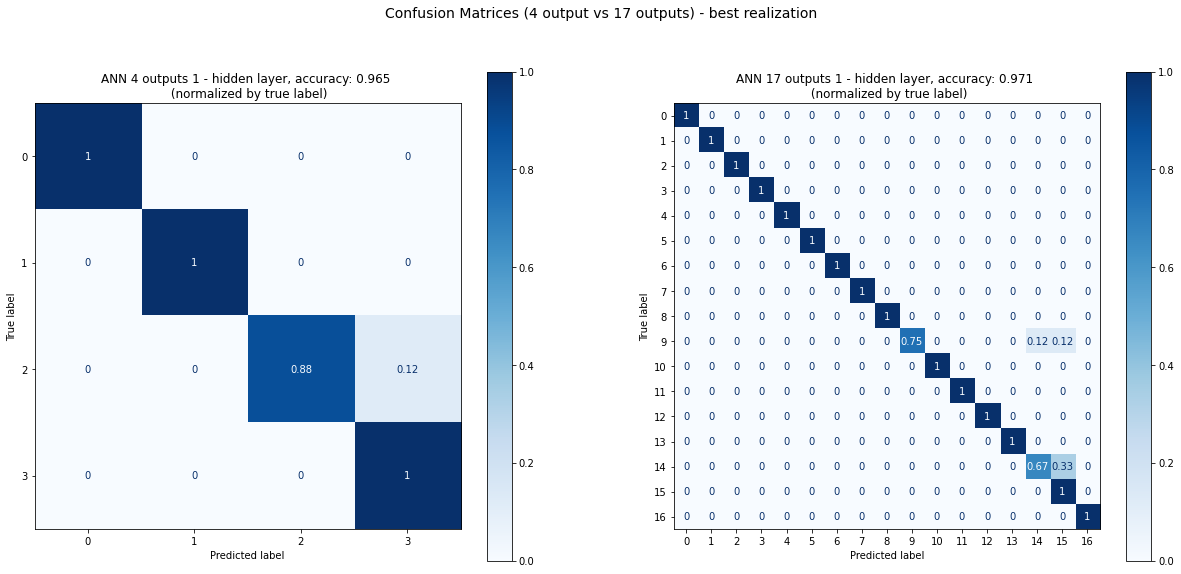

In [188]:
fig, ax = plt.subplots(1,2,figsize=(21,9))

disp_ann_group.plot(ax=ax[0], cmap=cmap)
disp_ann.plot(ax=ax[1], cmap=cmap)
# disp_ann_2h.plot(ax=ax[2], cmap=cmap)

ax[0].set_title(f'ANN 4 outputs 1 - hidden layer, accuracy: {accuracies_ann_group[best_i_04]:.3f} \n (normalized by true label)')
ax[1].set_title(f'ANN 17 outputs 1 - hidden layer, accuracy: {accuracies_ann[best_i_17]:.3f} \n (normalized by true label)')

fig.suptitle('Confusion Matrices (4 output vs 17 outputs) - best realization', fontsize=14)

pass;


### Soft Classifiers

Random Search (parametrization)

In [189]:
model_class = [
    'Bayesian',
    'Linear',
    'Linear',
    'Neighbor',
    'Trees',
    'Ensemble',
    'Ensemble',
    'Ensemble',
    'Ensemble'
]
model_labels = [
    'Gaussian\nNaive Bayes',
    'Logistic\nRegression',
    'SVM',
    'K-NN',
    'Decision\nTrees',
    'Random\nForest',
    'Adaboost',
    'Bagging',
    'Stacking'
]

In [190]:
stack_estimators = [
    ('LREG',LogisticRegression(max_iter=500)), 
    ('SVC',SVC()), 
    ('KNN',KNeighborsClassifier()), 
    ('RF',RandomForestClassifier()),
]

models = [
    ('GNB',GaussianNB()), 
    ('LREG',LogisticRegression(max_iter=500)), 
    ('SVC',SVC()), 
    ('KNN',KNeighborsClassifier()), 
    ('DTREE',DecisionTreeClassifier()), 
    ('RF',RandomForestClassifier()),
    ('ADAB',AdaBoostClassifier()),
    ('BAG',BaggingClassifier()),
    ('STACK',StackingClassifier(estimators=stack_estimators, final_estimator=LogisticRegression())),
]

params = []
params.append([# GNB = 0
    {
        'var_smoothing':  stats.uniform(1e-11,1e-7)
    }])
params.append([# SoftMax = 1
    {
        'penalty':  ['l1', 'l2', 'elasticnet', 'none'],
        'C':    stats.randint(1,25), # def=1
        'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
    }])
params.append([# SVC = 2
    {
        'C':  stats.randint(1,25), # def=1
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # excluded 'precomputed' cause it demands a square X matrix, not the case
        'degree': stats.randint(1,10), # def = 3
        # 'gamma': ['scale','auto']
    }])
params.append([# KNN = 3
    {
        'n_neighbors':  stats.randint(3,11), # def = 5
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
        'leaf_size': stats.randint(1,50) #def = 30            
    }])
params.append([# Decision Trees = 4
    {
        'criterion':  ['gini', 'entropy'], # d= gini
        # 'splitter':  ['best', 'random'], # d= best
        'max_features':  stats.uniform(), # d= None
        'max_depth':  stats.randint(3,20), # def = None

    }])
params.append([# Random Forest = 5
    {
        'n_estimators': stats.randint(2,100), # d= gini
        'criterion':  ['gini', 'entropy'], # d= gini
        'max_features':  stats.uniform(), # d= None
        'max_depth':  stats.randint(2,30), # def = None            
    }])
params.append([# adaboost = 6
    {
        'n_estimators'           : stats.randint(2,100),
        'learning_rate'          : stats.randint(0.01,10),
    }])
params.append([# Bagging classifier = 7
    {
        'n_estimators'           : stats.randint(5,100),
        'max_samples'            : stats.randint(0.1,20),            
        'max_features'           : stats.randint(0.1,8),             
    }])
params.append([# Stacking = 8
    {           
    # default
    }])

Random Search (fit)

In [191]:
n_iter = 100
n_jobs = -1
scoring = 'accuracy'

In [192]:
rscv_results = []
accuracies_soft = []

for i, rs in tqdm(enumerate(random_seeds)):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=rs)

    for k in range(len(models)):
        random_search = RandomizedSearchCV(models[k][1], verbose=0, scoring=scoring, param_distributions=params[k], n_iter=n_iter, n_jobs=n_jobs, cv=k_fold);
        random_search.fit(X_train, y_train)
        
        model = random_search.best_estimator_
        y_pred = model.predict(X_test)
        
        accuracies_soft.append(accuracy_score(y_test, y_pred))

        # saving rscv instance...
        rscv_results.append(random_search)
save_element(rscv_results, 'rscv.rscv')
pass;

0it [00:00, ?it/s]

c:\Users\bewm\AppData\Roaming\Python\env\env1\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.91911765        nan        nan 0.90588235        nan
        nan 0.90098039        nan        nan 0.90588235 0.92058824
        nan 0.91568627 0.90490196 0.9122549         nan 0.90490196
 0.91519608        nan 0.90343137 0.90980392 0.92107843 0.91666667
        nan        nan        nan        nan 0.92107843 0.92107843
 0.91862745 0.91470588 0.8745098         nan 0.92107843 0.91470588
        nan 0.91911765        nan 0.91470588        nan        nan
        nan 0.91666667 0.91470588 0.91862745        nan        nan
        nan 0.91470588        nan 0.90490196 0.92205882 0.91862745
        nan        nan 0.90343137        nan 0.90490196 0.90490196
 0.90931373 0.91862745 0.91617647 0.92107843        nan 0.92156863
        nan 0.91911765 0.90490196        nan        nan        nan
        nan        nan        na

saving objects

In [193]:
accuracies_soft = np.reshape(accuracies_soft, (n_seeds, len(models)))
accuracies_soft = np.transpose(accuracies_soft)

accuracies_soft.shape
save_element(accuracies_soft, 'accuracies_soft')

(9, 10)

In [194]:
avg_accuracies_soft = np.mean(accuracies_soft, axis=1)
avg_accuracies_soft

array([0.90941176, 0.92941176, 0.92470588, 0.90941176, 0.87      ,
       0.90764706, 0.76529412, 0.86823529, 0.91882353])

### ANN vs Soft Classifiers

Saving and plotting results

In [195]:
df_results = pd.DataFrame({
    'Model_Class': 'Neural Network', 
    'Model': 'Naural \nNetwork', 
    'Score': accuracies_ann, 
    })


In [196]:
indexes = [0,1,2,3,4,5,6,7,8] #excluindo 
for i in indexes:
# for i, accs in enumerate(accuracies_soft[indexes]):
    df_results = df_results.append(
        pd.DataFrame({
        'Model_Class': model_class[i],  
        'Model': model_labels[i], 
        'Score': accuracies_soft[i], 
    }))

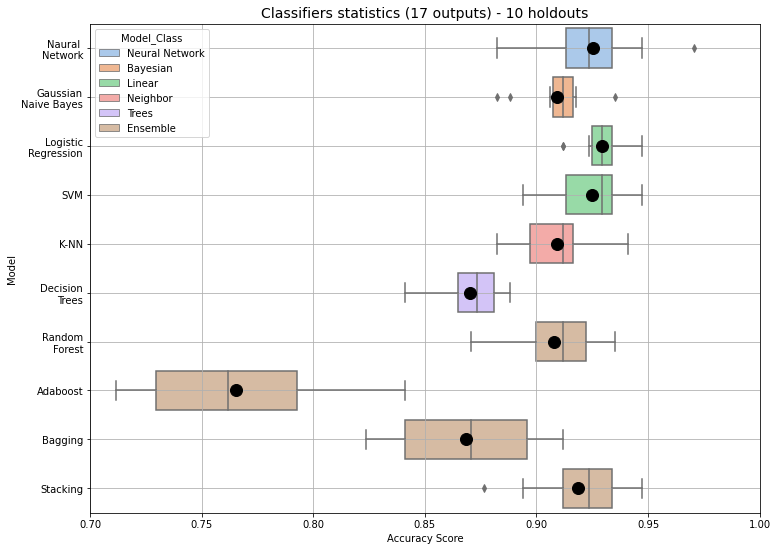

In [197]:
plt.figure(figsize=(12,9))
# sns.catplot(data=df_results, x='Model', y='Score', hue='Model_Class', height=6, aspect=1.3, kind='strip')
sns.boxplot(data=df_results, y='Model', x='Score', hue='Model_Class', dodge=False, palette='pastel', showmeans=True,
            meanprops={'marker':'o', 'markerfacecolor':'black', 'markeredgecolor':'black', 'markersize':'12'})
plt.title('Classifiers statistics (17 outputs) - 10 holdouts', fontsize=14)
plt.xlim((.7,1))
plt.ylabel('Model')
plt.xlabel('Accuracy Score')
plt.grid()
pass;

### Self Organizing Map

import library

In [28]:
# !git clone https://github.com/mdrs-thiago/minisom
from minisom.minisom import MiniSom

Parametrization

In [16]:
#Dimensão do vetor de entrada
input_len = X.shape[1]

topology = 'hexagonal'

# map dimensions
m = 12
n = 15

###############################
###############################
# 1a fase - Ordering Phase
###############################
###############################
ordering_lr = .9
ordering_time = 10000

# decay function 
def decay_fcn_ordering(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    new_lr = lr/(1 + 2*actual_t/max_t)
    return new_lr

###############################
###############################
# 2a fase - Fine Adjustment Phase 
#   Ideally alpha < 0.02 and constant
###############################
###############################
finetuning_lr = 0.002 # constant
finetuning_time = 800 * m * n
# finetuning_time = 5000

# decay function 
def decay_fcn_finetuning(lr,actual_t,max_t):
    return lr

Initialization

In [200]:
som = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering)
som.pca_weights_init(X)

Train: ordering phase

In [201]:
som.train_random(X, ordering_time, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.12080093786371728
Topographic error not computed.


In [202]:
quant_err = som._quantization_error
topo_err = som._topographic_error

In [203]:
som._learning_rate = finetuning_lr
som._decay_function = decay_fcn_finetuning

# ao final do treino de ordenalçao, sigma deve valer um terço do inicial. (new_lr = lr/(1 + 2*actual_t/max_t)
som._sigma = som._sigma / 3

Train: finetuning

In [204]:
som.train_random(X, finetuning_time, verbose=True)

 [ 144000 / 144000 ] 100% - 0:00:00 left 
 quantization error: 0.11445636639956203
Topographic error not computed.


In [205]:
quant_err += som._quantization_error
topo_err += som._topographic_error

Error plots

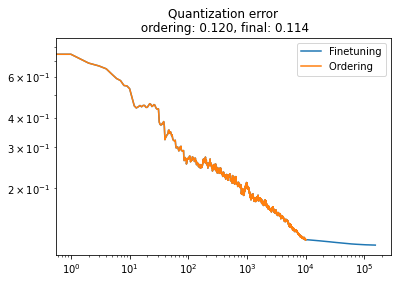

In [206]:
plt.plot(quant_err)
plt.plot(quant_err[:ordering_time])
plt.legend(['Finetuning','Ordering '])
plt.title(f'Quantization error\n ordering: {np.min(quant_err[:ordering_time]):.3f}, final: {quant_err[-1]:.3f}')
plt.xscale('log')
plt.yscale('log')
pass;

Som results

0.28867513459481287


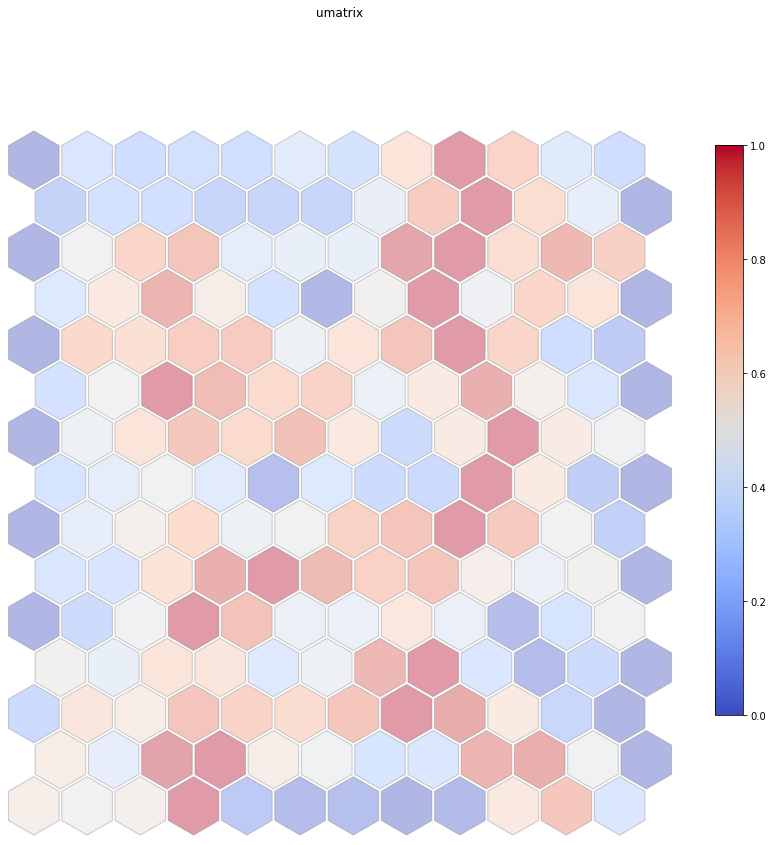

In [207]:
# som.plot_umatrix(names=[f'After finetunning\n{somname_file}'])
som.plot_umatrix()

Plotting classes over the map

In [208]:
import matplotlib.lines as mlines

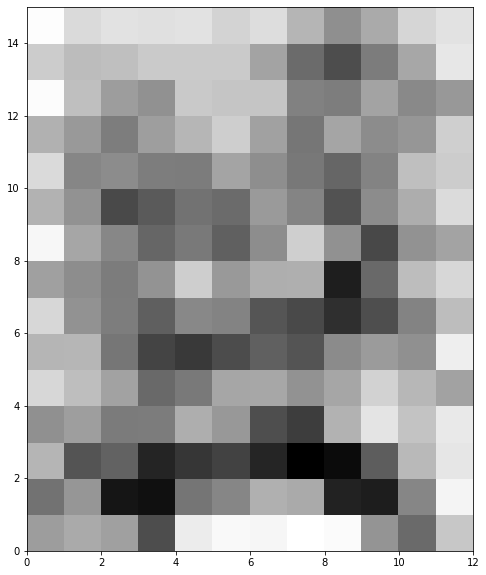

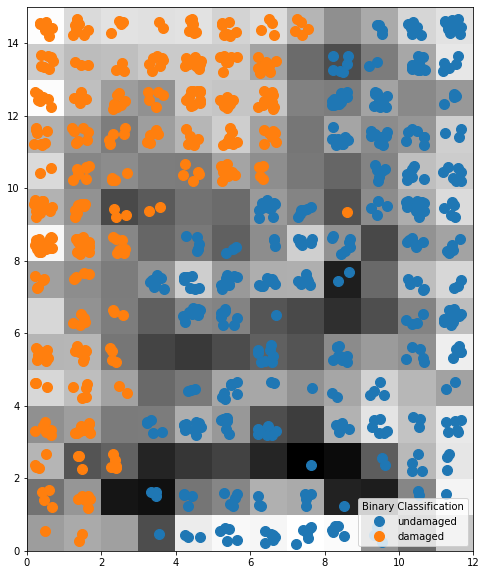

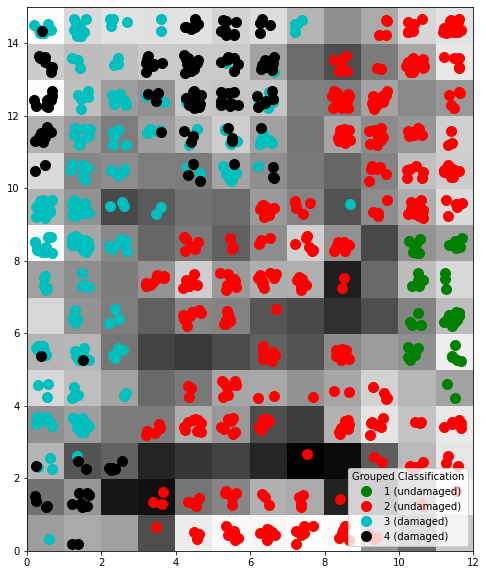

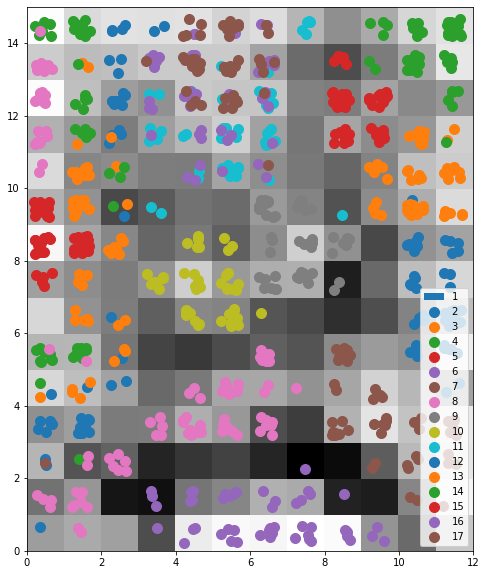

In [209]:
s=(8,10)
a=1
cmap = 'binary'

# unsup
f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)
plt.show()
pass;

# bin
y=target_bin
y=y.astype(int)
y_labels = np.unique(y)

colors = ['C0', 'C1']
# marker = ['o', 'o']
f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)

for c in np.unique(y):
    idx_y = y==c
    plt.scatter(w_x[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5,
                w_y[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5, 
                s=100, c=colors[c], label=y_labels[c])

lh1 = mlines.Line2D([], [], color='C0', marker='o', markersize=10, linestyle='None', label='undamaged')
lh2 = mlines.Line2D([], [], color='C1', marker='o', markersize=10, linestyle='None', label='damaged')

plt.legend(handles=[lh1, lh2], title='Binary Classification')
plt.show()
pass;

# group
y=target_group
y=y.astype(int)
y_labels = np.unique(y)
y_labels

colors = ['g', 'r', 'c', 'k']
# marker = ['o', 'o', 'o', 'o']

f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)
for c in np.unique(y):
    idx_y = y==c
    plt.scatter(w_x[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5,
                w_y[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5, 
                s=100, c=colors[c], label=y_labels[c])

lh1 = mlines.Line2D([], [], color='g', marker='o', markersize=10, linestyle='None', label='1 (undamaged)')
lh2 = mlines.Line2D([], [], color='r', marker='o', markersize=10, linestyle='None', label='2 (undamaged)')
lh3 = mlines.Line2D([], [], color='c', marker='o', markersize=10, linestyle='None', label='3 (damaged)')
lh4 = mlines.Line2D([], [], color='k', marker='o', markersize=10, linestyle='None', label='4 (damaged)')

plt.legend(handles=[lh1, lh2, lh3, lh4], title='Grouped Classification')
plt.show()

# 17 states
y=target
y=y.astype(int)
y_labels = np.unique(y)

f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)
for c in np.unique(y):
    idx_y = y==c
    plt.scatter(w_x[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5,
                w_y[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5, 
                s=100)

plt.legend([i+1 for i in range(17)])
plt.show()
pass;


pass;

Aumentando tamanho do mapa para contemplar mais clusters (feito apos a apresentação como sugestão da professora)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.07031714712083754
Topographic error not computed.
 [ 375000 / 375000 ] 100% - 0:00:00 left 
 quantization error: 0.06518118398451303
Topographic error not computed.
0.28867513459481287


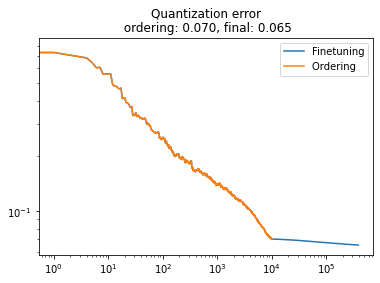

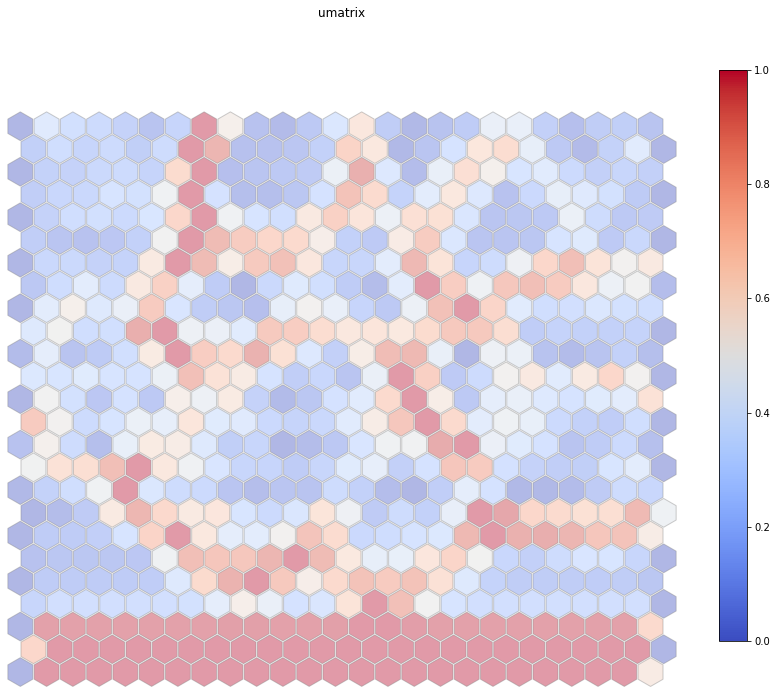

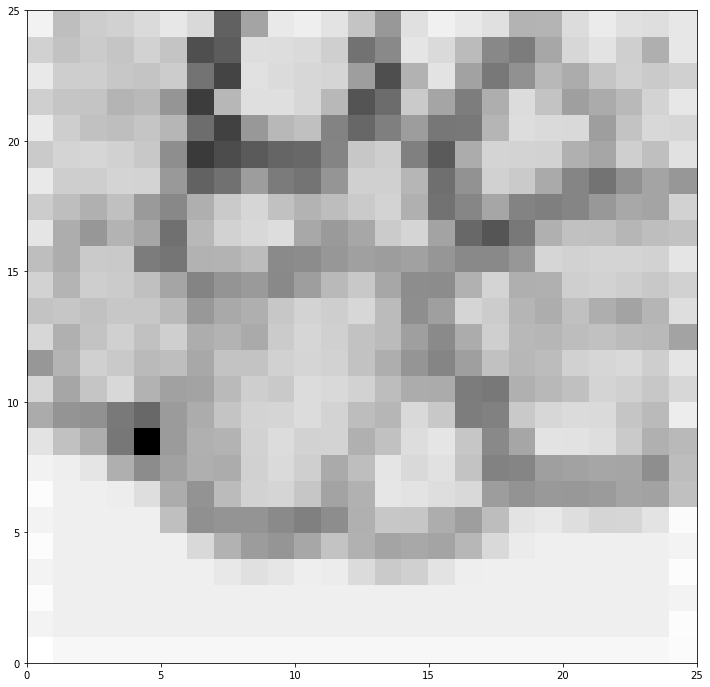

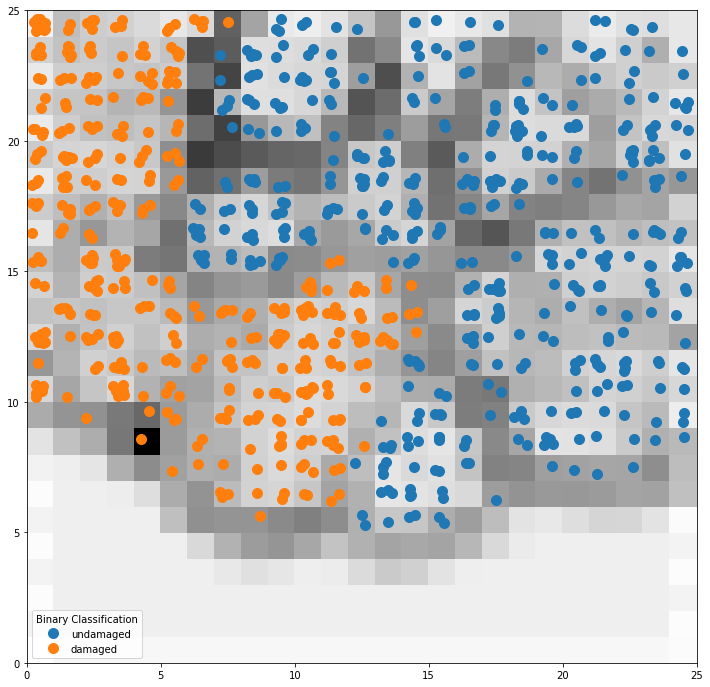

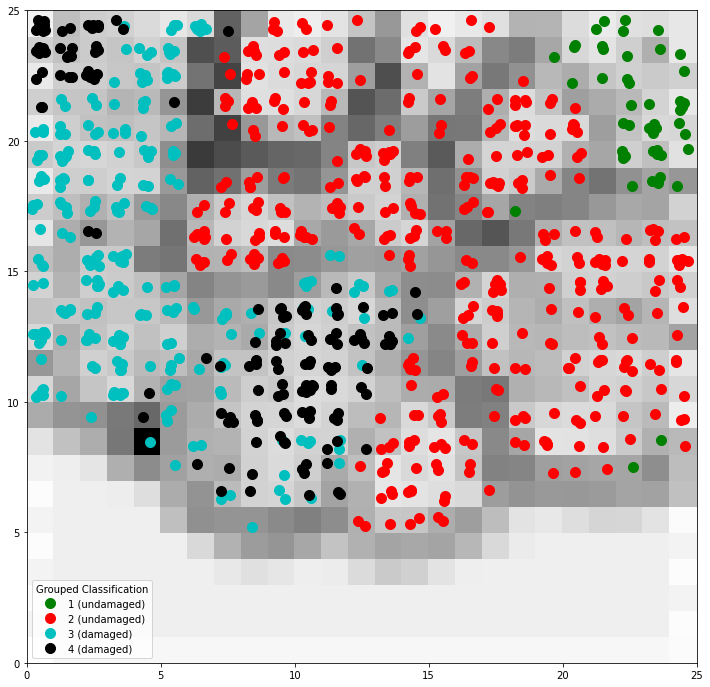

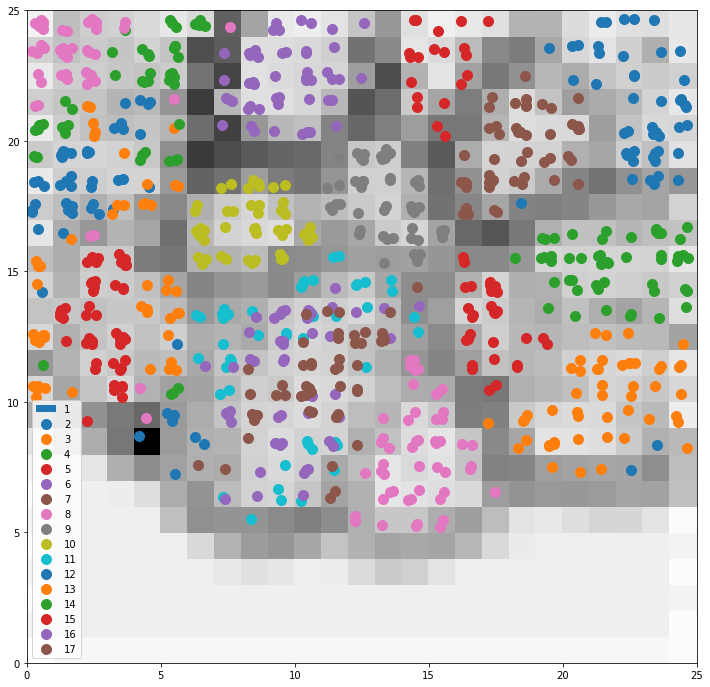

In [30]:
#Dimensão do vetor de entrada
input_len = X.shape[1]
topology = 'hexagonal'

# map dimensions
m = 25
n = 25

###############################
###############################
# 1a fase - Ordering Phase
###############################
###############################
ordering_lr = .9
ordering_time = 10000

# decay function 
def decay_fcn_ordering(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    new_lr = lr/(1 + 2*actual_t/max_t)
    return new_lr

###############################
###############################
# 2a fase - Fine Adjustment Phase 
#   Ideally alpha < 0.02 and constant
###############################
###############################
finetuning_lr = 0.002 # constant
finetuning_time = 600 * m * n
# finetuning_time = 5000

# decay function 
def decay_fcn_finetuning(lr,actual_t,max_t):
    return lr

# Initialization
som = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering)
som.pca_weights_init(X)

# Train: ordering phase
som.train_random(X, ordering_time, verbose=True)

quant_err = som._quantization_error
topo_err = som._topographic_error
som._learning_rate = finetuning_lr
som._decay_function = decay_fcn_finetuning

# ao final do treino de ordenalçao, sigma deve valer um terço do inicial. (new_lr = lr/(1 + 2*actual_t/max_t)
som._sigma = som._sigma / 3

# Train: finetuning
som.train_random(X, finetuning_time, verbose=True)
quant_err += som._quantization_error
topo_err += som._topographic_error

# Error plots
plt.plot(quant_err)
plt.plot(quant_err[:ordering_time])
plt.legend(['Finetuning','Ordering '])
plt.title(f'Quantization error\n ordering: {np.min(quant_err[:ordering_time]):.3f}, final: {quant_err[-1]:.3f}')
plt.xscale('log')
plt.yscale('log')
pass;

# Som results
# som.plot_umatrix(names=[f'After finetunning\n{somname_file}'])
som.plot_umatrix()


# Plotting classes over the map
s=(12,12)
a=1
cmap = 'binary'

# unsup
f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)
plt.show()
pass;

# bin
y=target_bin
y=y.astype(int)
y_labels = np.unique(y)

colors = ['C0', 'C1']
# marker = ['o', 'o']
f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)

for c in np.unique(y):
    idx_y = y==c
    plt.scatter(w_x[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5,
                w_y[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5, 
                s=100, c=colors[c], label=y_labels[c])

lh1 = mlines.Line2D([], [], color='C0', marker='o', markersize=10, linestyle='None', label='undamaged')
lh2 = mlines.Line2D([], [], color='C1', marker='o', markersize=10, linestyle='None', label='damaged')

plt.legend(handles=[lh1, lh2], title='Binary Classification')
plt.show()
pass;

# group
y=target_group
y=y.astype(int)
y_labels = np.unique(y)
y_labels

colors = ['g', 'r', 'c', 'k']
# marker = ['o', 'o', 'o', 'o']

f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)
for c in np.unique(y):
    idx_y = y==c
    plt.scatter(w_x[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5,
                w_y[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5, 
                s=100, c=colors[c], label=y_labels[c])

lh1 = mlines.Line2D([], [], color='g', marker='o', markersize=10, linestyle='None', label='1 (undamaged)')
lh2 = mlines.Line2D([], [], color='r', marker='o', markersize=10, linestyle='None', label='2 (undamaged)')
lh3 = mlines.Line2D([], [], color='c', marker='o', markersize=10, linestyle='None', label='3 (damaged)')
lh4 = mlines.Line2D([], [], color='k', marker='o', markersize=10, linestyle='None', label='4 (damaged)')

plt.legend(handles=[lh1, lh2, lh3, lh4], title='Grouped Classification')
plt.show()

# 17 states
y=target
y=y.astype(int)
y_labels = np.unique(y)

f = plt.figure(figsize=s)
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.pcolor(som.distance_map().T, cmap=cmap, alpha=a)
for c in np.unique(y):
    idx_y = y==c
    plt.scatter(w_x[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5,
                w_y[idx_y]+.2+(np.random.rand(np.sum(idx_y))-.02)*.5, 
                s=100)

plt.legend([i+1 for i in range(17)])
plt.show()
pass;
